# Data simulation

In [1]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano
import theano.tensor as tt
import scipy
import os
import update_q

import pymc3 as pm
import arviz as az

In [2]:
reinf_rate = pd.read_csv('data/db_trials.csv')
reinf_rate = reinf_rate[reinf_rate['sub']==115].sort_values('trialNum').reset_index(drop=True)
reinf_rate = reinf_rate[['trialNum', 'rectOri', 'rectValue']]
reinf_rate.shape

(70, 3)

In [3]:
tune = 2000 # 2000
draws = 2000
target_accept = .95 #.99

n_subj = 10

In [4]:
stim = reinf_rate.rectOri.values/45
stim = stim.astype(int)
reward = reinf_rate.rectValue.values.astype(int)/6
reward = reward.astype(int)

In [5]:
stim = stim[:35]
reward = reward[:35]

In [6]:
def add_sub_single(alpha):
    df = pd.DataFrame()
    cs = [.5, .5]
    rating = [5, 5]
    PE = 0
    for i in range(len(stim)):
        trial = {'trial': i, 'CS': stim[i], 'reward': reward[i], 'PE':PE, 'value': cs[stim[i]], 'rating': rating[stim[i]]}
        PE = reward[i] - cs[stim[i]]
        value = cs[stim[i]] + alpha * PE
        rating[stim[i]] = round(value*9,0)
        if rating[stim[i]] < 1:
            rating[stim[i]] = 1
        cs[stim[i]]=value
        temp = pd.DataFrame(trial, index=[i])
        df= pd.concat([df,temp])
    return df

In [7]:
alpha = np.random.beta(a=3, b=5, size=n_subj)

In [8]:
df = pd.DataFrame()
sub = 0
for a in alpha:
    ss = add_sub_single(a)
    ss['sub'] = sub
    ss['alpha'] = a
    sub += 1
    df = pd.concat([df,ss])

<AxesSubplot:xlabel='trial', ylabel='reward'>

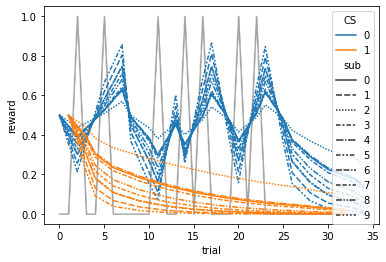

In [9]:
sns.lineplot(data=df, x='trial', y='reward', alpha=.2, color='black')
sns.lineplot(data=df, x='trial', y='value', hue='CS', style='sub')

In [10]:
trials, subj = np.meshgrid(range(len(stim)), range(n_subj))
stims = np.reshape(np.tile(stim, n_subj), (n_subj,len(stim))).T
rewards = np.reshape(np.tile(reward, n_subj), (n_subj,len(stim))).T
ratings = np.reshape(df.value.values, (n_subj,len(stim))).T
trial = (trials<36)*1

trials = tt.as_tensor_variable(trials.T)
trial = tt.as_tensor_variable(trial.T)
subj = tt.as_tensor_variable(subj.T)
stims = tt.as_tensor_variable(stim)
rewards = tt.as_tensor_variable(rewards)
ratings = tt.as_tensor_variable(ratings)

In [11]:
with pm.Model() as model_RW_H:
    
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd',2) 
    intercept = pm.Normal('intercept', mu, sd, shape=n_subj)
    
    beta_h = pm.Normal('beta_h', 0,1)
    beta_sd = pm.HalfNormal('beta_sd', 1)
    beta = pm.Normal('beta',beta_h, beta_sd, shape=n_subj)
    
    eps = pm.HalfNormal('eps', 5)
    
    a_a = pm.TruncatedNormal('a_a', 3, 2, lower=1)
    a_b = pm.TruncatedNormal('a_b', 7, 2, lower=1)

    alpha = pm.Beta('alpha', a_a, a_b, shape=n_subj)
    
    
    Qs = .5 * tt.ones((n_subj,2), dtype='float64') # set values for boths stimuli (CS+, CS-)
    vec = .5 * tt.ones((n_subj,1), dtype='float64') # vector to save the relevant stimulus's expactation
    
    [Qs,vec], updates = theano.scan(
        fn=update_q.update_Q,
        sequences=[stims, rewards],
        outputs_info=[Qs, vec],
        non_sequences=[alpha, n_subj])
   
    
    vec_ = vec[trials,subj,0] * beta[subj] + intercept[subj]
    
    learn = pm.Normal('learn', vec_, eps, observed=ratings) 
    
    # add matrix of expected values (trials X subjects)
    ev = pm.Deterministic('expected_value', vec_)
    
    trace_RW_h = pm.sample(tune=tune, draws=draws, return_inferencedata=True, target_accept= target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, a_b, a_a, eps, beta, beta_sd, beta_h, intercept, sd, mu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2321 seconds.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
There were 96 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [12]:
az.summary(trace_RW_h,var_names=['alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.124,0.018,0.091,0.157,0.000,0.000,1723.0,3839.0,1.00
alpha[1],0.201,0.025,0.156,0.250,0.001,0.000,1765.0,3457.0,1.00
alpha[2],0.081,0.013,0.058,0.106,0.000,0.000,2538.0,3800.0,1.00
alpha[3],0.163,0.022,0.123,0.206,0.001,0.000,1538.0,2104.0,1.00
alpha[4],0.121,0.018,0.090,0.155,0.000,0.000,1455.0,2987.0,1.01
alpha[5],0.220,0.027,0.172,0.275,0.001,0.001,1486.0,1943.0,1.00
alpha[6],0.179,0.023,0.135,0.222,0.001,0.000,1639.0,3392.0,1.00
alpha[7],0.131,0.019,0.099,0.170,0.000,0.000,1520.0,1833.0,1.00
alpha[8],0.150,0.021,0.112,0.189,0.001,0.000,1525.0,3570.0,1.00
alpha[9],0.178,0.023,0.134,0.223,0.001,0.000,1549.0,3246.0,1.00


In [13]:
df['alpha'].unique()

array([0.22304416, 0.48624791, 0.12500119, 0.34335469, 0.21500431,
       0.57258735, 0.40059879, 0.24140085, 0.29809978, 0.39634083])